# Stock Forecasting — Extended Models (TensorFlow)

"
This notebook extends a forecasting project by adding **additional models** to compare against LSTM and Transformer:

- **Baseline MLP (feedforward)**
- **LSTM (recurrent)**
- **GRU (lighter recurrent)**
- **1D-CNN (convolutional time-series)**
- **Transformer encoder (attention-based)**

Each model is implemented in Keras, trained on the same sliding-window dataset, and evaluated with common metrics (MSE, MAE, MAPE, R²). The notebook includes explanations before each section to understand the choices and results.



In [1]:
!pip install -q yfinance tensorflow matplotlib scikit-learn ta joblib

  Preparing metadata (setup.py) ... done


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import joblib

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

print('TensorFlow version:', tf.__version__)


TensorFlow version: 2.19.0


## 1) Data Loading & Quick EDA

We’re working with historical daily OHLCV data for a selected ticker (default: `AAPL`). For this project, we mainly use the **Close** price and create a few basic features around it. In a real production setup, we’d expand this by adding external factors and using a walk-forward evaluation approach.


In [3]:
# Configuration
SYMBOL = 'AAPL'    # change to any ticker supported by yfinance
START_DATE = '2015-01-01'
END_DATE = None
SEQ_LEN = 60
BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-3
PATIENCE = 5

# Download
print('Downloading', SYMBOL)
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False)
print('Rows downloaded:', len(df))
df = df[['Open','High','Low','Close','Volume']].dropna()


/tmp/ipython-input-416570044.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False)


Rows downloaded: 2675



## 2) Features & Preprocessing

For the features, we’re keeping it simple: the **Close** price, daily returns, a couple of moving averages, volatility, and RSI. We scale the features and targets separately to prevent data leakage. Then, we build sliding windows of length `SEQ_LEN` so the model can learn from sequences of past data.

In [4]:
def add_features(df):
    d = df.copy()
    d['Return_1d'] = d['Close'].pct_change().fillna(0)
    d['SMA_10'] = d['Close'].rolling(window=10).mean()
    d['SMA_20'] = d['Close'].rolling(window=20).mean()
    d['Vol_10'] = d['Return_1d'].rolling(window=10).std()

    # RSI (Relative Strength Index)
    delta = d['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    rs = roll_up / (roll_down + 1e-8)
    d['RSI_14'] = 100.0 - (100.0 / (1.0 + rs))

    d = d.fillna(0)
    return d

feat_df = add_features(df)
feature_cols = ['Close','Return_1d','SMA_10','SMA_20','Vol_10','RSI_14']

# Scale
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_all = X_scaler.fit_transform(feat_df[feature_cols])
y_all = y_scaler.fit_transform(feat_df[['Close']])

# Sliding windows
def make_sequences(X, y, seq_len=60):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X, y = make_sequences(X_all, y_all, seq_len=SEQ_LEN)

# Split
train_end = int(0.7 * len(X))
val_end = int(0.85 * len(X))
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
print('Shapes ->', X_train.shape, X_val.shape, X_test.shape)

Shapes -> (1830, 60, 6) (392, 60, 6) (393, 60, 6)


## 3) Baseline: MLP (Feedforward)

As a starting point, we’re using a simple MLP. It just flattens the past `SEQ_LEN` days into a single vector and passes it through a small fully-connected network. Having this kind of baseline is important because, on noisy financial data, even simple models can sometimes perform as well as (or better than) more complex ones.

In [5]:
def build_mlp(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Flatten()(inp)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')
    return model

## 4) LSTM

Long Short-Term Memory networks (LSTMs) are a type of RNN designed to capture long-term dependencies. We'll use a stacked LSTM with dropout.

In [6]:
def build_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(128, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')
    return model

## 5) GRU

Gated Recurrent Units (GRUs) are similar to LSTMs but with fewer parameters — often faster to train with similar performance.

In [7]:

def build_gru(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(128, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.GRU(64)(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')
    return model

## 6) 1D-CNN

A 1D convolution can learn local temporal filters (e.g., short momentum patterns). CNNs are efficient and sometimes outperform RNNs on certain time-series tasks.

In [8]:

def build_cnn(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(inp)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')
    return model

## 7) Transformer (compact)

A compact Transformer encoder — attention mechanism that can capture global dependencies. We keep it small to run on CPUs quickly.

In [9]:
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

    def call(self, x):
        seq_len = tf.shape(x)[1]
        i = tf.range(seq_len)[:, tf.newaxis]
        j = tf.range(self.d_model)[tf.newaxis, :]
        j = tf.cast(j, tf.float32)
        angle_rates = 1 / tf.pow(10000., (2 * (j//2)) / tf.cast(self.d_model, tf.float32))
        angle_rads = tf.cast(i, tf.float32) * angle_rates
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return x + pos_encoding[:, :seq_len, :]

def build_transformer(input_shape, d_model=64, nhead=2, ff_dim=128):
    inp = layers.Input(shape=input_shape)
    x = layers.Dense(d_model)(inp)
    x = PositionalEncoding(d_model)(x)
    attn = layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    ff = layers.Dense(ff_dim, activation='relu')(x)
    ff = layers.Dense(d_model)(ff)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')
    return model

# Model Training

In [10]:
model_dict = {
    'MLP': build_mlp((SEQ_LEN, len(feature_cols))),
    'LSTM': build_lstm((SEQ_LEN, len(feature_cols))),
    'GRU': build_gru((SEQ_LEN, len(feature_cols))),
    'CNN': build_cnn((SEQ_LEN, len(feature_cols))),
    'Transformer': build_transformer((SEQ_LEN, len(feature_cols)))
}

for name, model in model_dict.items():
    print(f"Training {name}...")
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)],
        verbose=1
    )

Training MLP...
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0646 - val_loss: 0.0090
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0133
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0189
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0164
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0126
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0095
Training LSTM...
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0156 - val_loss: 8.6840e-04
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0718e-04 - val_loss: 7.3438e-04
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7307e-04 - val_loss: 7.7528e-04
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5275e-04 - val_loss: 5.5115e-04
Epoch 5/20

## 8) Evaluation & Model Comparison

We evaluate all models on the held-out test set using MSE, MAE, MAPE, and R². We also plot predictions to visually inspect performance.

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
         Model         MSE        MAE    MAPE_%        R2
2          GRU   46.271886   5.179819  2.410558  0.910534
4  Transformer   90.209106   7.963686  3.679476  0.825583
1         LSTM  121.383582   8.718265  3.998596  0.765307
3          CNN  329.604993  15.656327  7.206513  0.362715
0          MLP  362.908829  15.442738  7.202201  0.298323


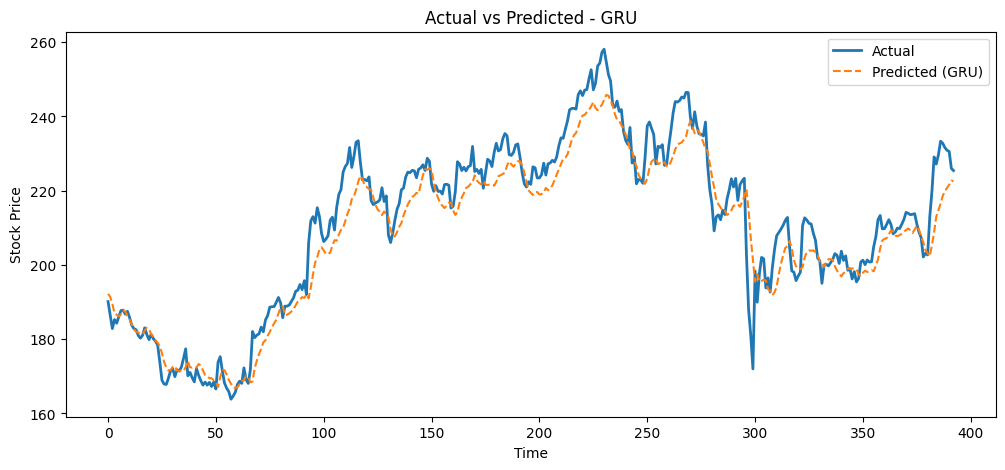

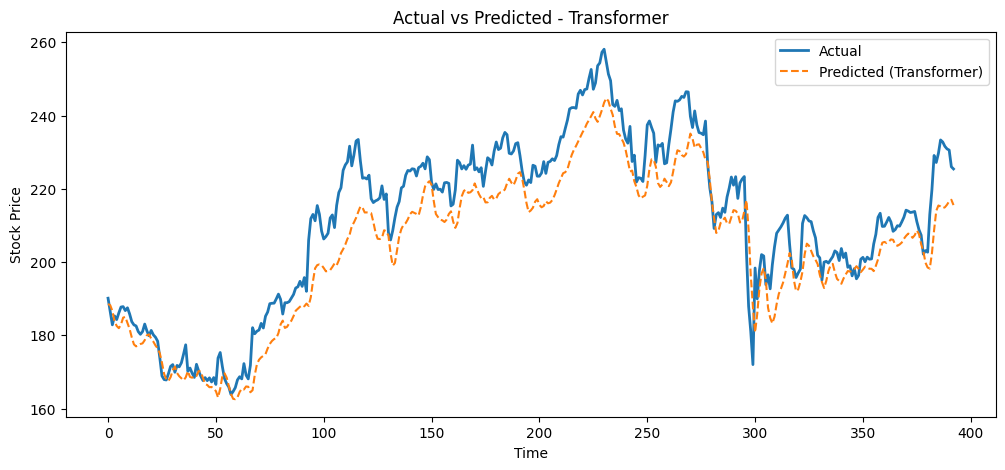

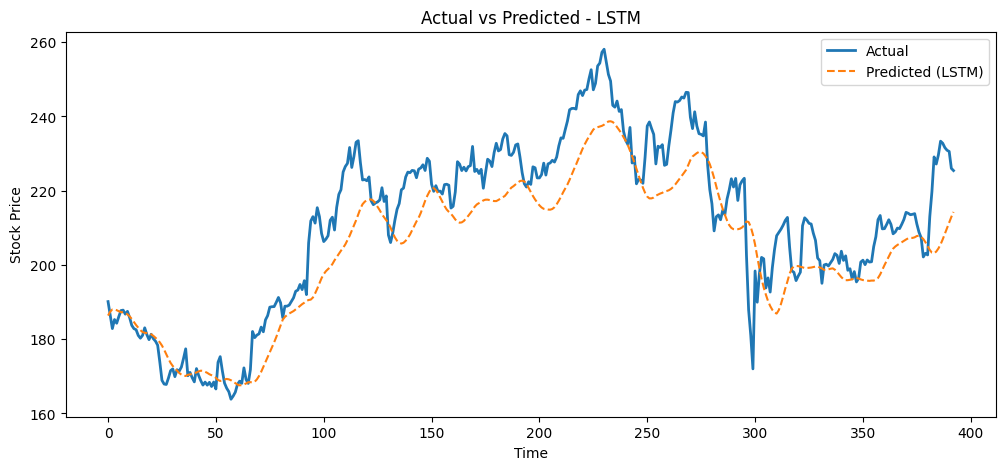

In [11]:
results = []
all_preds = {}

for name, model in model_dict.items():
    preds = model.predict(X_test)
    preds = preds.reshape(-1, 1)
    preds_inv = y_scaler.inverse_transform(preds)
    y_inv = y_scaler.inverse_transform(y_test)

    mse = mean_squared_error(y_inv, preds_inv)
    mae = mean_absolute_error(y_inv, preds_inv)
    mape = np.mean(np.abs((y_inv - preds_inv) / (y_inv + 1e-8))) * 100
    r2 = r2_score(y_inv, preds_inv)

    results.append({'Model': name, 'MSE': mse, 'MAE': mae, 'MAPE_%': mape, 'R2': r2})
    all_preds[name] = preds_inv

# Sort by best MSE
res_df = pd.DataFrame(results).sort_values('MSE')
print(res_df)

# Get top 3 models
best_models = res_df['Model'].tolist()[:3]

# Plot separately for each top model
for name in best_models:
    plt.figure(figsize=(12,5))
    plt.plot(y_inv, label='Actual', linewidth=2)
    plt.plot(all_preds[name], label=f'Predicted ({name})', linestyle='--')
    plt.legend()
    plt.title(f'Actual vs Predicted - {name}')
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.show()


## 9) Save Models

Save trained models and scalers for reuse and include a helper function to forecast the next day using the most recent `SEQ_LEN` observations.

In [13]:
import os
import joblib
from google.colab import files

# Create artifacts/ folder if not exists
os.makedirs("artifacts", exist_ok=True)

# Train and save each model
for name, model in model_dict.items():
    print(f"\n🔹 Saving {name}...")
    model_save_path = f"artifacts/{name}_model.h5"
    model.save(model_save_path)
    print(f"✅ {name} saved at {model_save_path}")

    # Download immediately
    files.download(model_save_path)

joblib.dump(X_scaler, "artifacts/X_scaler.pkl")
joblib.dump(y_scaler, "artifacts/y_scaler.pkl")

print("✅ Saved X_scaler and y_scaler in artifacts/")


🔹 Saving MLP...
✅ MLP saved at artifacts/MLP_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔹 Saving LSTM...
✅ LSTM saved at artifacts/LSTM_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔹 Saving GRU...
✅ GRU saved at artifacts/GRU_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔹 Saving CNN...
✅ CNN saved at artifacts/CNN_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔹 Saving Transformer...
✅ Transformer saved at artifacts/Transformer_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved X_scaler and y_scaler in artifacts/
